<a href="https://colab.research.google.com/github/czeacach/fashion_designers/blob/main/Affinage_Distribution_nationalit%C3%A9s_fashiondesigners.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Affinage de la distribution des nationalités(= country of citizenship) des créateurs.trices de mode et de leur évolution dans le temps


Dans ce carnet est proposé un affinage de l'exploration des nationalités (country-of-citizenship). de la population Wikidata retenue en divisant les régions d'Europe selon le Schéma. géographique des Nations Unies qui a été créé pour l'analyse statistique.

Schéma géographique des Nations-Unies des sous régions de l'Europe : Europe du Nord, Europe  de l'Ouest, Europe de l'Est, Europe du Sud

On s'efforcera de répondre aux questions suivantes:

Quelles sont les origines géographiques des créateurs/créatrices de mode?

Y a-t-il eu une évolution notable de l'origine géographique des créateurs/créatrices de mode?

**NB:** Une personne peut avoir plusieurs nationalités (= country of citizenship.

Les catégories utilisées sont celles des continents selon le World Fact Book de la CIA (l'Antarctique n'a pas été inclus, car aucune donnée n'y correspondait)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
!pip install itables

In [ ]:
from itables import init_notebook_mode, show

init_notebook_mode(all_interactive=False)

In [ ]:
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

In [ ]:
### Librairies déjà installées avec Python
import pprint
import csv
import sys

import sqlite3 as sql

import time
import datetime
from dateutil import parser

from importlib import reload
from shutil import copyfile

#Explorer les nationalités

In [ ]:
### Se connecter à la base de données dans laquelle on va insérer
# le résultat de la requête SPARQL
#chemin d'acces de la base de données directement connectée à l'ordinateur via Google Drive Desktop
'/content/drive/MyDrive/dossier de travail/fashion_designers_data_analysis.db'
cn = sql.connect('/content/drive/MyDrive/dossier de travail/fashion_designers_data_analysis.db')
cn

In [ ]:
### Le nombre de nationalités différents: noter qu'il y des répétitions
## et inconsistances dans les données de Wikidata

q="""
SELECT COUNT(*)
FROM wdt_nationality
"""
cur = cn.cursor()
r = cur.execute(q).fetchone()
print('Nombre de nationalités différentes:' , r[0])

Nombre de nationalités différentes: 164


In [ ]:
### Compter les occurrences de chaque nationalités
q="""
-- noter que la fonction TRIM élimine les éventuels espaces en début ou fin de chaine de charactères
-- la fonction LOWER met tout au minuscule
SELECT TRIM(nationalityUri) as nationalityUri, LOWER(TRIM(nationalityLabel)) AS nationalityLabel, COUNT(*) as effectif
FROM wdt_person_nationality
GROUP BY TRIM(nationalityUri), LOWER(TRIM(nationalityLabel))
ORDER BY effectif DESC
"""
cur = cn.cursor()
r = cur.execute(q).fetchall()
rdf = pd.DataFrame(r,columns=['uri', 'label', 'freq'])
rdf.head()

,uri,label,freq
0,http://www.wikidata.org/entity/Q30,united states of america,556
1,http://www.wikidata.org/entity/Q145,united kingdom,235
2,http://www.wikidata.org/entity/Q142,france,213
3,http://www.wikidata.org/entity/Q17,japan,163
4,http://www.wikidata.org/entity/Q38,italy,150


# Explorer les personnes en relation avec leur(s) nationalité(s)

## Affinage de l'analyse en rajoutant les régions d'Europe

In [ ]:
### Créer la requête SQL et inspecter le résultat
# Noter les jointures entre les différentes tables
q = """
SELECT wp.personUri, wp.personLabel, MIN(wp.genderUri) AS gender,
       MIN(wp.birthYear) AS birthYear,
       GROUP_CONCAT(DISTINCT TRIM(wpo.nationalityLabel)) AS nationalityLabels,
       GROUP_CONCAT(DISTINCT TRIM(er.europe_regionLabel)) AS europeRegionLabels
FROM wdt_person_nationality wpo
JOIN wdt_personne wp ON wp.personUri = wpo.personUri
JOIN wdt_nationality wn ON wn.nationalityUri = wpo.nationalityUri
JOIN europe_regions er ON er.pk_europe_region = wn.fk_europe_region
GROUP BY wp.personUri, wp.personLabel;
"""
cur = cn.cursor()
r = cur.execute(q).fetchall()
[e for e in r][:3]

[('http://www.wikidata.org/entity/Q100324415',
  'Estrella Rivas Franco',
  'http://www.wikidata.org/entity/Q6581072',
  '1921',
  'Spain',
  'southern_europe'),
 ('http://www.wikidata.org/entity/Q100462257',
  'Ina Trifonova',
  'http://www.wikidata.org/entity/Q6581072',
  '1981',
  'Bulgaria',
  'eastern_europe'),
 ('http://www.wikidata.org/entity/Q101611457',
  'Dennis Klaverweide',
  'http://www.wikidata.org/entity/Q6581097',
  '1990',
  'Kingdom of the Netherlands',
  'western_europe')]

In [ ]:
### Créer la requête SQL et inspecter le résultat
# Noter les jointures entre les différentes tables
q = """
SELECT
    wp.personUri,
    wp.personLabel,
    MIN(wp.genderUri) AS gender,
    MIN(wp.birthYear) AS birthYear,
    GROUP_CONCAT(DISTINCT TRIM(wn.nationalityLabel)) AS nationalityLabels,
    GROUP_CONCAT(DISTINCT TRIM(wc.continentLabel)) AS continentLabels,
    GROUP_CONCAT(DISTINCT TRIM(er.europe_regionLabel)) AS europeRegionLabels
FROM
    wdt_person_nationality wpo
JOIN
    wdt_personne wp ON wp.personUri = wpo.personUri
JOIN
    wdt_nationality wn ON wpo.nationalityUri = wn.nationalityUri
JOIN
    continents wc ON wn.fk_continent = wc.pk_continent
LEFT JOIN
    europe_regions er ON er.pk_europe_region = wn.fk_europe_region
GROUP BY
    wp.personUri, wp.personLabel;
        """
cur = cn.cursor()
r = cur.execute(q).fetchall()
[e for e in r][:3]

[('http://www.wikidata.org/entity/Q100324415',
  'Estrella Rivas Franco',
  'http://www.wikidata.org/entity/Q6581072',
  '1921',
  'spain',
  'Europe',
  'southern_europe'),
 ('http://www.wikidata.org/entity/Q100462257',
  'Ina Trifonova',
  'http://www.wikidata.org/entity/Q6581072',
  '1981',
  'bulgaria',
  'Europe',
  'eastern_europe'),
 ('http://www.wikidata.org/entity/Q101085725',
  'Abbas Kaijuka',
  'http://www.wikidata.org/entity/Q6581097',
  '1989',
  'uganda',
  'Africa',
  None)]

#Créer le tableau à analyser

In [ ]:
### On transforme la liste en DataFrame

df_p = pd.DataFrame(r, columns=['person_uri', 'person_label',
                        'genderUri', 'birthYear', 'nationalités', 'continents', 'europe_regions'])
df_p = df_p.set_index('person_uri',drop=True)

df_p.head()

,person_label,genderUri,birthYear,nationalités,continents,europe_regions
person_uri,,,,,,
http://www.wikidata.org/entity/Q100324415,Estrella Rivas Franco,http://www.wikidata.org/entity/Q6581072,1921,spain,Europe,southern_europe
http://www.wikidata.org/entity/Q100462257,Ina Trifonova,http://www.wikidata.org/entity/Q6581072,1981,bulgaria,Europe,eastern_europe
http://www.wikidata.org/entity/Q101085725,Abbas Kaijuka,http://www.wikidata.org/entity/Q6581097,1989,uganda,Africa,None
http://www.wikidata.org/entity/Q101611457,Dennis Klaverweide,http://www.wikidata.org/entity/Q6581097,1990,kingdom of the netherlands,Europe,western_europe
http://www.wikidata.org/entity/Q101627961,Sepehr Maghsoudi,http://www.wikidata.org/entity/Q6581097,1982,kingdom of the netherlands,Europe,western_europe


In [ ]:
# nombre d'instances = lignes du dataframe
print(len(df_p))


2856


## Ajout des listes de nationalités, continents, régions d'europe en tant que colonnes

In [ ]:
# Ajout de colonnes avec des listes
df_p['l_nationalités'] = df_p['nationalités'].apply(lambda x: x.split(',') if x else [])
df_p['l_continents'] = df_p['continents'].apply(lambda x: x.split(',') if x else [])
df_p['l_europe_regions'] = df_p['europe_regions'].apply(lambda x: x.split(',') if x else [])

# Ajout de colonnes avec le nombre d'éléments dans les listes
df_p['length_l_nationalités'] = df_p['l_nationalités'].apply(len)
df_p['length_l_continents'] = df_p['l_continents'].apply(len)
df_p['length_l_europe_regions'] = df_p['l_europe_regions'].apply(len)

df_p.tail()

,person_label,genderUri,birthYear,nationalités,continents,europe_regions,l_nationalités,l_continents,l_europe_regions,length_l_nationalités,length_l_continents,length_l_europe_regions
person_uri,,,,,,,,,,,,
http://www.wikidata.org/entity/Q99478791,Iveta Karklina-Viksne,http://www.wikidata.org/entity/Q6581072,1970,latvia,Europe,northern_europe,[latvia],[Europe],[northern_europe],1,1,1
http://www.wikidata.org/entity/Q99529091,Nelson Enwerem,http://www.wikidata.org/entity/Q6581097,1995,nigeria,Africa,None,[nigeria],[Africa],[],1,1,0
http://www.wikidata.org/entity/Q99572935,Adejoke Lasisi,http://www.wikidata.org/entity/Q6581072,1986,nigeria,Africa,None,[nigeria],[Africa],[],1,1,0
http://www.wikidata.org/entity/Q99578171,Gerhard Weber,http://www.wikidata.org/entity/Q6581097,1941,germany,Europe,western_europe,[germany],[Europe],[western_europe],1,1,1
http://www.wikidata.org/entity/Q99615223,Yemi Osunkoya,http://www.wikidata.org/entity/Q6581097,1969,nigeria,Africa,None,[nigeria],[Africa],[],1,1,0


## Coder le genre

In [ ]:
### On créé d'abord une fonction qui effectue le travail

## l'argument de la fonction 'g_uri' est un nom choisi librement
# il est ensuite appelé dans la fonction comme variable
# et contient la valeur introduite lors de l'utilisation de la fonction
def code_gender(g_uri):
    if g_uri == 'http://www.wikidata.org/entity/Q6581097':
        # genre masculin
        a = 'M'
    elif g_uri =='http://www.wikidata.org/entity/Q6581072':
        # genre féminin
        a = 'F'
    else:
        # genre autre
        a = 'A'
    return a

In [ ]:
### On ajoute une nouvelle colonne et y on met pour chaque ligne le résultat de la fonction
df_p['gender'] = df_p.apply(lambda x: code_gender(x['genderUri']), axis=1)

## on élimine la colonne originale
df_p = df_p.drop(columns=['genderUri'])
### On inspecte les cinq premières lignes qui ont la valeur 'A' = autre
df_p[df_p['gender']=='A'][:5]

,person_label,birthYear,nationalités,continents,europe_regions,l_nationalités,l_continents,l_europe_regions,length_l_nationalités,length_l_continents,length_l_europe_regions,gender
person_uri,,,,,,,,,,,,
http://www.wikidata.org/entity/Q107910513,Kataluna Enriquez,1995,united states of america,North America,None,[united states of america],[North America],[],1,1,0,A
http://www.wikidata.org/entity/Q116025164,Patricia Ramírez,1981,argentina,South America,None,[argentina],[South America],[],1,1,0,A
http://www.wikidata.org/entity/Q118730875,Chaoko,1997,spain,Europe,southern_europe,[spain],[Europe],[southern_europe],1,1,1,A
http://www.wikidata.org/entity/Q121887025,Robertina Manganaro,1958,italy,Europe,southern_europe,[italy],[Europe],[southern_europe],1,1,1,A
http://www.wikidata.org/entity/Q12501502,Asha Smara Darra,1977,indonesia,Asia,None,[indonesia],[Asia],[],1,1,0,A


In [ ]:
### Effectifs par genre
df_p.groupby(by='gender', observed=True).size()

gender
A      16
F    1586
M    1254
dtype: int64

## Ajouter les périodes

In [ ]:
# transformer l'année en entier
df_p['birthYear'] = df_p['birthYear'].astype(int)
# limiter aux personnes nées avant le 21e siècle
df_p = df_p[df_p['birthYear'] < 2001].copy(deep=True)
# vérifier année minimale et maximale
print(min(df_p['birthYear']),max(df_p['birthYear']))

1801 2000


In [ ]:
### Créer neuf périodes
l_per = [1801, 1826, 1851, 1876, 1901, 1926, 1951, 1976, 2001]

In [ ]:
### fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année

df_p['periodes'] = pd.cut(df_p['birthYear'], l_per, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
df_p['periodes'] = df_p['periodes'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
df_p.head(3)

,person_label,birthYear,nationalités,continents,europe_regions,l_nationalités,l_continents,l_europe_regions,length_l_nationalités,length_l_continents,length_l_europe_regions,gender,periodes
person_uri,,,,,,,,,,,,,
http://www.wikidata.org/entity/Q100324415,Estrella Rivas Franco,1921,spain,Europe,southern_europe,[spain],[Europe],[southern_europe],1,1,1,F,1901-1925
http://www.wikidata.org/entity/Q100462257,Ina Trifonova,1981,bulgaria,Europe,eastern_europe,[bulgaria],[Europe],[eastern_europe],1,1,1,F,1976-2000
http://www.wikidata.org/entity/Q101085725,Abbas Kaijuka,1989,uganda,Africa,None,[uganda],[Africa],[],1,1,0,M,1976-2000


In [ ]:
### Effectifs par période
df_p.groupby(by='periodes', observed=True).size()

periodes
1801-1825      11
1826-1850       9
1851-1875      42
1876-1900     132
1901-1925     267
1926-1950     520
1951-1975    1009
1976-2000     866
dtype: int64

## Pour pouvoir réaliser le tableau de contingence --> nécessité de choisir une seule nationalité

In [ ]:
# Sélectionner le premier élément de chaque liste dans la colonne 'l_continents'
first_continent = df_p['l_continents'].str[0]
first_nationality = df_p['l_nationalités'].str[0]

# Créer un nouveau DataFrame avec la première nationalité uniquement
df_p_first_continent = df_p.copy()  # Faire une copie du DataFrame original
df_p_first_continent['first_continent'] = first_continent  # Ajouter la colonne 'first_continent'
df_p_first_continent['first_nationality'] = first_nationality # Ajouter la colonne 'first_nationality'

# Supprimer la colonne 'l_nationalités' si nécessaire
# df_p_first_nationality = df_p_first_nationality.drop(columns=['l_nationalités'])

# Inspection
df_p_first_continent.tail()

,person_label,birthYear,nationalités,continents,europe_regions,l_nationalités,l_continents,l_europe_regions,length_l_nationalités,length_l_continents,length_l_europe_regions,gender,periodes,first_continent,first_nationality
person_uri,,,,,,,,,,,,,,,
http://www.wikidata.org/entity/Q99478791,Iveta Karklina-Viksne,1970,latvia,Europe,northern_europe,[latvia],[Europe],[northern_europe],1,1,1,F,1951-1975,Europe,latvia
http://www.wikidata.org/entity/Q99529091,Nelson Enwerem,1995,nigeria,Africa,None,[nigeria],[Africa],[],1,1,0,M,1976-2000,Africa,nigeria
http://www.wikidata.org/entity/Q99572935,Adejoke Lasisi,1986,nigeria,Africa,None,[nigeria],[Africa],[],1,1,0,F,1976-2000,Africa,nigeria
http://www.wikidata.org/entity/Q99578171,Gerhard Weber,1941,germany,Europe,western_europe,[germany],[Europe],[western_europe],1,1,1,M,1926-1950,Europe,germany
http://www.wikidata.org/entity/Q99615223,Yemi Osunkoya,1969,nigeria,Africa,None,[nigeria],[Africa],[],1,1,0,M,1951-1975,Africa,nigeria


In [ ]:
# Sélectionner le premier élément de chaque liste dans la colonne 'l_europe_regions'
first_europe_region = df_p['l_europe_regions'].str[0]

# Créer un nouveau DataFrame avec la première nationalité uniquement
df_p_world_region = df_p.copy()  # Faire une copie du DataFrame original

df_p_world_region['first_continent'] = first_continent  # Ajouter la colonne 'first_continent'

df_p_world_region['first_europe_region'] = first_europe_region  # Ajouter la colonne 'first_europe_region'

# Supprimer les colonnes pas nécessaires
df_p_world_region = df_p_world_region.drop(columns=['length_l_nationalités', 'length_l_continents', 'length_l_europe_regions'])

# Inspection
df_p_world_region.tail()

,person_label,birthYear,nationalités,continents,europe_regions,l_nationalités,l_continents,l_europe_regions,gender,periodes,first_continent,first_europe_region
person_uri,,,,,,,,,,,,
http://www.wikidata.org/entity/Q99478791,Iveta Karklina-Viksne,1970,latvia,Europe,northern_europe,[latvia],[Europe],[northern_europe],F,1951-1975,Europe,northern_europe
http://www.wikidata.org/entity/Q99529091,Nelson Enwerem,1995,nigeria,Africa,None,[nigeria],[Africa],[],M,1976-2000,Africa,NaN
http://www.wikidata.org/entity/Q99572935,Adejoke Lasisi,1986,nigeria,Africa,None,[nigeria],[Africa],[],F,1976-2000,Africa,NaN
http://www.wikidata.org/entity/Q99578171,Gerhard Weber,1941,germany,Europe,western_europe,[germany],[Europe],[western_europe],M,1926-1950,Europe,western_europe
http://www.wikidata.org/entity/Q99615223,Yemi Osunkoya,1969,nigeria,Africa,None,[nigeria],[Africa],[],M,1951-1975,Africa,NaN


In [ ]:
## création d'une fonction pour sélectionner les régions à analyser, en affinant l'Europe

def determine_world_region(row):
    if row['first_continent'] == 'Europe':
        return row['first_europe_region']
    else:
        return row['first_continent']

# Appliquer la fonction à chaque ligne du DataFrame
df_p_world_region['world_region'] = df_p_world_region.apply(determine_world_region, axis=1)

# Inspection
df_p_world_region.tail()

,person_label,birthYear,nationalités,continents,europe_regions,l_nationalités,l_continents,l_europe_regions,gender,periodes,first_continent,first_europe_region,world_region
person_uri,,,,,,,,,,,,,
http://www.wikidata.org/entity/Q99478791,Iveta Karklina-Viksne,1970,latvia,Europe,northern_europe,[latvia],[Europe],[northern_europe],F,1951-1975,Europe,northern_europe,northern_europe
http://www.wikidata.org/entity/Q99529091,Nelson Enwerem,1995,nigeria,Africa,None,[nigeria],[Africa],[],M,1976-2000,Africa,NaN,Africa
http://www.wikidata.org/entity/Q99572935,Adejoke Lasisi,1986,nigeria,Africa,None,[nigeria],[Africa],[],F,1976-2000,Africa,NaN,Africa
http://www.wikidata.org/entity/Q99578171,Gerhard Weber,1941,germany,Europe,western_europe,[germany],[Europe],[western_europe],M,1926-1950,Europe,western_europe,western_europe
http://www.wikidata.org/entity/Q99615223,Yemi Osunkoya,1969,nigeria,Africa,None,[nigeria],[Africa],[],M,1951-1975,Africa,NaN,Africa


# Périodes et régions du monde où sont né.e.s les créateurs et créatrices de mode




## Tableau de contingence

In [ ]:
### La fonction pivot_table produit un tableau de contingence
## Au centre du tableau se trouvent les effectifs conjoints,
## aux bords les effectifs marginaux qui correspondent
## aux distributions indépendantes des variables

X = "world_region"  # "0"
Y = "periodes"

c_obs_continents_periodes = df_p_world_region[[Y,X]].pivot_table(index=Y,columns=X,aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
c_obs_continents_periodes

world_region,Africa,Asia,North America,Oceania,South America,eastern_europe,northern_europe,southern_europe,western_europe,Total
periodes,,,,,,,,,,
1801-1825,0,0,2,0,0,0,3,0,6,11
1826-1850,0,0,1,0,0,2,3,1,2,9
1851-1875,0,0,2,1,0,0,8,3,28,42
1876-1900,0,2,38,1,2,3,7,23,56,132
1901-1925,2,17,71,8,17,6,40,51,55,267
1926-1950,5,74,88,16,25,22,105,81,104,520
1951-1975,25,155,192,34,67,52,190,110,184,1009
1976-2000,74,151,190,18,54,63,120,66,129,865
Total,106,399,584,78,165,148,476,335,564,2855


In [ ]:
### Fréquence conjointe et fréquence marginale (proportion par rapport au total)

c_obs_continents_periodes = np.round(c_obs_continents_periodes*100/c_obs_continents_periodes.iloc[-1,-1],1)
c_obs_continents_periodes

world_region,Africa,Asia,North America,Oceania,South America,eastern_europe,northern_europe,southern_europe,western_europe,Total
periodes,,,,,,,,,,
1801-1825,0.0,0.0,0.1,0.0,0.0,0.0,0.1,0.0,0.2,0.4
1826-1850,0.0,0.0,0.0,0.0,0.0,0.1,0.1,0.0,0.1,0.3
1851-1875,0.0,0.0,0.1,0.0,0.0,0.0,0.3,0.1,1.0,1.5
1876-1900,0.0,0.1,1.3,0.0,0.1,0.1,0.2,0.8,2.0,4.6
1901-1925,0.1,0.6,2.5,0.3,0.6,0.2,1.4,1.8,1.9,9.4
1926-1950,0.2,2.6,3.1,0.6,0.9,0.8,3.7,2.8,3.6,18.2
1951-1975,0.9,5.4,6.7,1.2,2.3,1.8,6.7,3.9,6.4,35.3
1976-2000,2.6,5.3,6.7,0.6,1.9,2.2,4.2,2.3,4.5,30.3
Total,3.7,14.0,20.5,2.7,5.8,5.2,16.7,11.7,19.8,100.0


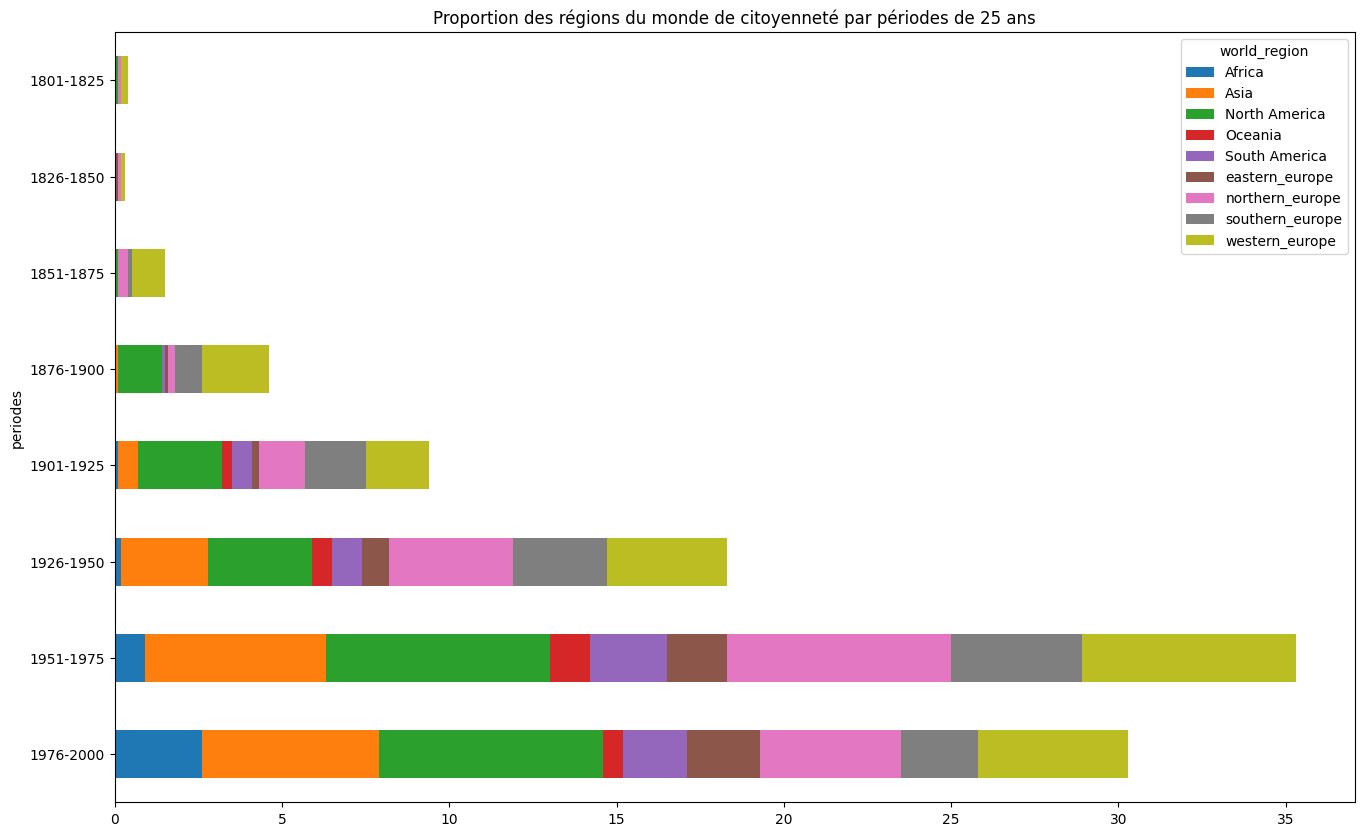

In [ ]:
### Effectifs des continents par périodes
g = c_obs_continents_periodes.iloc[:-1, :-1].sort_index(ascending=False)\
        .plot( kind='barh', stacked=True,  figsize=(16,10),  title = 'Proportion des régions du monde de citoyenneté par périodes de 25 ans')

In [ ]:
### pourcentages des lignes
stacked_data_lignes = c_obs_continents_periodes.apply(lambda x: (x*100/sum(x)*2).round(2), axis=1) # axis=0
stacked_data_lignes

world_region,Africa,Asia,North America,Oceania,South America,eastern_europe,northern_europe,southern_europe,western_europe,Total
periodes,,,,,,,,,,
1801-1825,0.00,0.00,25.00,0.00,0.00,0.00,25.00,0.00,50.00,100.00
1826-1850,0.00,0.00,0.00,0.00,0.00,33.33,33.33,0.00,33.33,100.00
1851-1875,0.00,0.00,6.67,0.00,0.00,0.00,20.00,6.67,66.67,100.00
1876-1900,0.00,2.17,28.26,0.00,2.17,2.17,4.35,17.39,43.48,100.00
1901-1925,1.06,6.38,26.60,3.19,6.38,2.13,14.89,19.15,20.21,100.00
1926-1950,1.10,14.25,16.99,3.29,4.93,4.38,20.27,15.34,19.73,99.73
1951-1975,2.55,15.30,18.98,3.40,6.52,5.10,18.98,11.05,18.13,100.00
1976-2000,8.58,17.49,22.11,1.98,6.27,7.26,13.86,7.59,14.85,100.00
Total,3.70,13.99,20.49,2.70,5.80,5.20,16.69,11.69,19.79,99.95


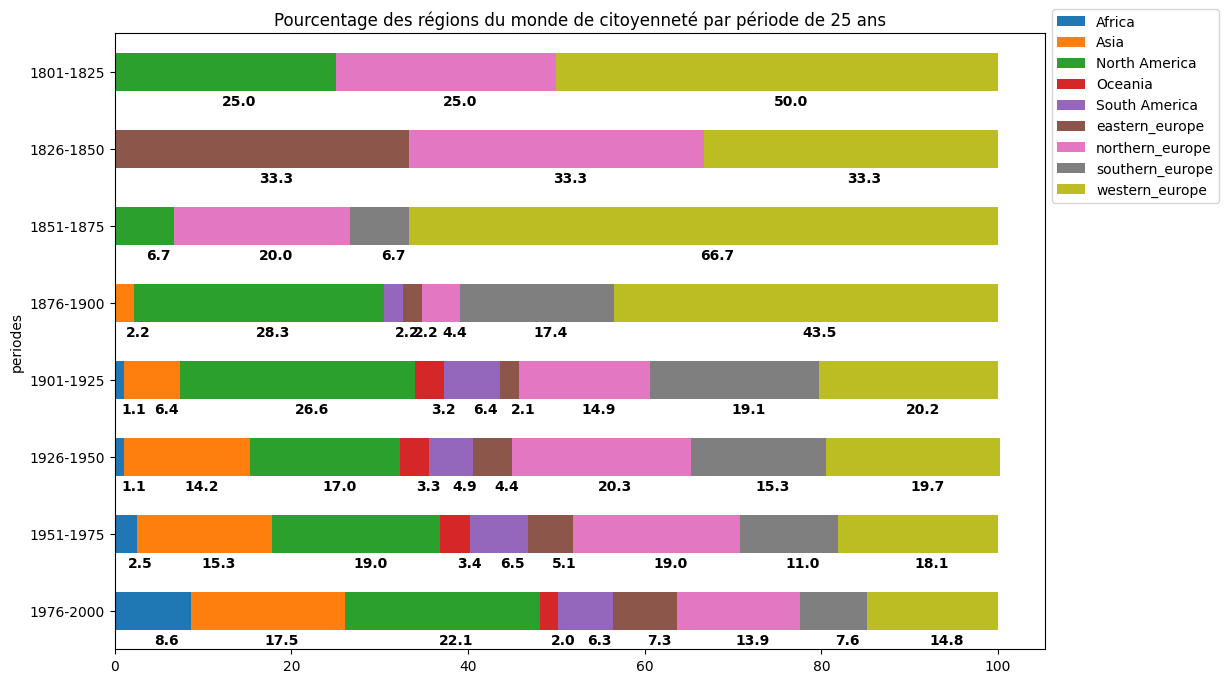

In [ ]:
z = stacked_data_lignes.iloc[:-1, :-1].sort_index(ascending=False).plot(kind="barh", stacked=True, figsize=(12,8), title='Pourcentage des régions du monde de citoyenneté par période de 25 ans')


# Annotation des valeurs sur les barres
for p in z.patches:
    b = p.get_bbox()
    width = b.x1 - b.x0
    if width >= 0.02:  # Exclure les valeurs inférieures à 0.02 de la légende
        z.annotate(
            format(width, '.1f'),
            (b.x0 + width / 2, b.y1),
            ha='center', va='center',
            size=10,
            weight='bold',
            color='black',
            xytext=(10, -35),
            textcoords='offset points'
        )

z.legend(bbox_to_anchor=(1, 1.05))

plt.show()

**Commentaire**

On constate que l'Europe du Nord et de l'Ouest sont très présentes sur l'ensemble des périodes, mais on observe au recul à partir de la fin du 19e siècle où l'Europe du Sud et l'Amérique du Nord prennent de l'ampleur. L'Europe du sud décline après la Seconde Guerre mondiale, mais l'Amérique du Nord reste la région du monde la plus représentée.

Au 20e siècle, l'Asie va prendre de l'ampleur et pour la période 1976-2000, supplante l'Europe du Nord et l'Europe de l'Ouest.




# Analyse de l'Europe uniquement

### Tableau de contingence

In [ ]:
### La fonction pivot_table produit un tableau de contingence
## Au centre du tableau se trouvent les effectifs conjoints,
## aux bords les effectifs marginaux qui correspondent
## aux distributions indépendantes des variables

X = "first_europe_region"  # "0"
Y = "periodes"

c_obs_europe_regions_periodes = df_p_world_region[[Y,X]].pivot_table(index=Y,columns=X,aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
c_obs_europe_regions_periodes

first_europe_region,eastern_europe,northern_europe,southern_europe,western_europe,Total
periodes,,,,,
1801-1825,0,3,0,6,9
1826-1850,2,3,1,2,8
1851-1875,0,8,3,28,39
1876-1900,6,7,23,56,92
1901-1925,9,40,51,60,160
1926-1950,22,106,82,106,316
1951-1975,53,194,111,191,549
1976-2000,63,126,69,134,392
Total,155,487,340,583,1565


In [ ]:
### Fréquence conjointe et fréquence marginale (proportion par rapport au total)

c_obs_europe_regions_periodes = np.round(c_obs_europe_regions_periodes*100/c_obs_europe_regions_periodes.iloc[-1,-1],1)
c_obs_europe_regions_periodes

first_europe_region,eastern_europe,northern_europe,southern_europe,western_europe,Total
periodes,,,,,
1801-1825,0.0,0.2,0.0,0.4,0.6
1826-1850,0.1,0.2,0.1,0.1,0.5
1851-1875,0.0,0.5,0.2,1.8,2.5
1876-1900,0.4,0.4,1.5,3.6,5.9
1901-1925,0.6,2.6,3.3,3.8,10.2
1926-1950,1.4,6.8,5.2,6.8,20.2
1951-1975,3.4,12.4,7.1,12.2,35.1
1976-2000,4.0,8.1,4.4,8.6,25.0
Total,9.9,31.1,21.7,37.3,100.0


In [ ]:
### pourcentages des lignes
stacked_data_lignes = c_obs_europe_regions_periodes.apply(lambda x: (x*100/sum(x)*2).round(2), axis=1) # axis=0
stacked_data_lignes

first_europe_region,eastern_europe,northern_europe,southern_europe,western_europe,Total
periodes,,,,,
1801-1825,0.00,33.33,0.00,66.67,100.00
1826-1850,20.00,40.00,20.00,20.00,100.00
1851-1875,0.00,20.00,8.00,72.00,100.00
1876-1900,6.78,6.78,25.42,61.02,100.00
1901-1925,5.85,25.37,32.20,37.07,99.51
1926-1950,6.93,33.66,25.74,33.66,100.00
1951-1975,9.69,35.33,20.23,34.76,100.00
1976-2000,15.97,32.34,17.56,34.33,99.80
Total,9.90,31.10,21.70,37.30,100.00


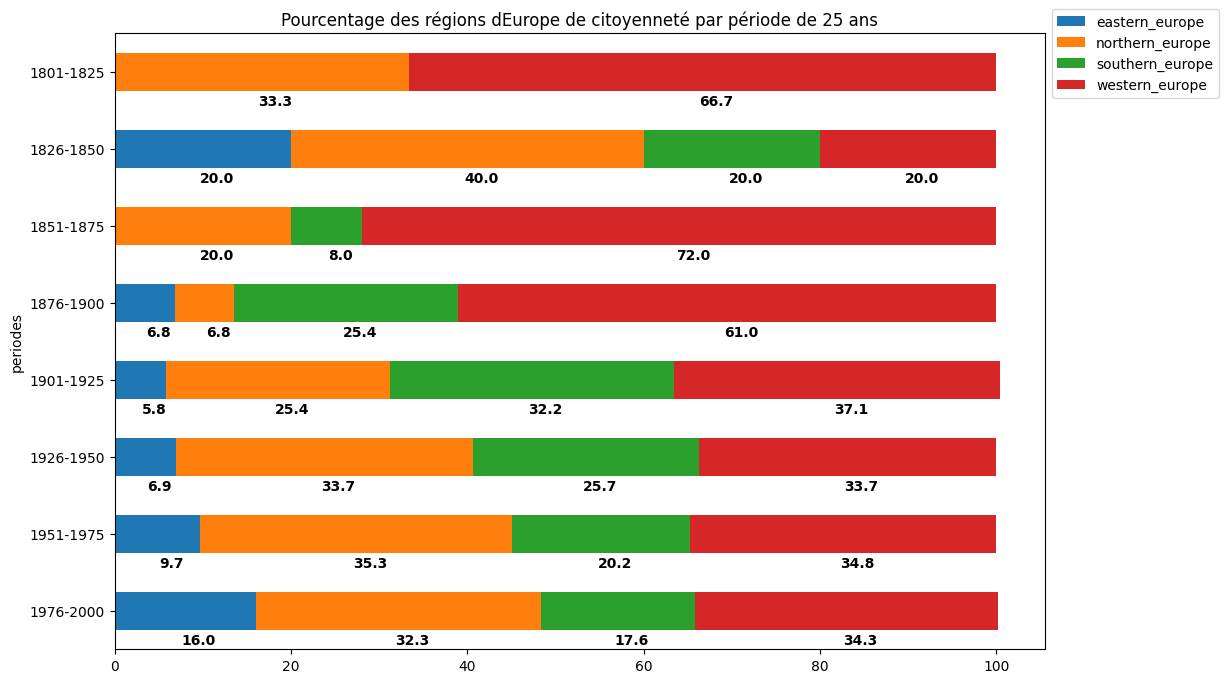

In [ ]:
### https://www.shanelynn.ie/bar-plots-in-python-using-pandas-dataframes/

z = stacked_data_lignes.iloc[:-1, :-1].sort_index(ascending=False).plot(kind="barh", stacked=True, figsize=(12,8), title='Pourcentage des régions dEurope de citoyenneté par période de 25 ans')

# Annotation des valeurs sur les barres
for p in z.patches:
    b = p.get_bbox()
    width = b.x1 - b.x0
    if width >= 0.02:  # Exclure les valeurs inférieures à 0.02 de la légende
        z.annotate(
            format(width, '.1f'),
            (b.x0 + width / 2, b.y1),
            ha='center', va='center',
            size=10,
            weight='bold',
            color='black',
            xytext=(10, -35),
            textcoords='offset points'
        )

z.legend(bbox_to_anchor=(1, 1.05))

plt.show()

**Commentaire**

On constate que l'Europe de l'Est est la moins représentée, sauf pour la période 1826-1850 (empire austro-hongrois, mouvements artisitiques à Vienne).

A partir du 20e siècle, on constate une répartition homogème entre l'Europe du Sud, de l'Ouest et du Nord avec un léger délcin de l'Europe du Sud à partir de 1976, au profit de l'Europe de l'Est.

# Distribution des pays de naissance les plus fréquents dans le temps

**Nettoyage des données**

* Pour l'Italie et la Grande-Bretagne, nécessité de regrouper plusieurs nationalités séparées dans wikidata.

* Pour l'Italie, regrouper : "italy" "kingdom of italy" et "republic of venice"

* Pour la Grande-Bretagne, regrouper: " united kingdom", "united kingdom of great britain and ireland", "kingdom of england", "england" et "wales".



In [ ]:
# Calculer le nombre d'occurrences de chaque nationalité
nationality_counts = df_p_first_continent['first_nationality'].value_counts().reset_index()

# Renommer les colonnes pour plus de clarté
nationality_counts.columns = ['nationalité', 'occurence']

# Afficher les premières lignes du DataFrame résultant
nationality_counts.head()

,nationalité,occurence
0,united states of america,549
1,united kingdom,214
2,france,195
3,japan,155
4,italy,147


In [ ]:
### Regrouper et compter avec un fitre sur le pays united states of america
nationality_usa = pd.DataFrame(df_p_first_continent[df_p_first_continent.first_nationality == 'united states of america'].groupby('periodes').size())
nationality_usa.columns = ['usa']
nationality_usa.tail()



,usa
periodes,
1876-1900,38
1901-1925,69
1926-1950,81
1951-1975,180
1976-2000,176


In [ ]:
### Regrouper et compter avec un fitre sur le pays united kingdom
# Filtrer les lignes où 'first_nationality' correspond à l'une des valeurs spécifiées
nationalities_to_filter = [
    'united kingdom',
    'united kingdom of great britain and ireland',
    'kingdom of england',
    'wales',
    'england'
]

# Filtrer les lignes qui correspondent aux nationalités spécifiées
filtered_df = df_p_first_continent[df_p_first_continent['first_nationality'].isin(nationalities_to_filter)]

# Regrouper par 'periodes' et compter les occurrences
nationality_uk = filtered_df.groupby('periodes').size().reset_index(name='united kingdom')

# Reset index without adding it as a new column
nationality_uk = filtered_df.groupby('periodes').size().reset_index(name='united kingdom').set_index('periodes')

# Afficher les dernières lignes du DataFrame
nationality_uk.tail()


,united kingdom
periodes,
1876-1900,2
1901-1925,18
1926-1950,45
1951-1975,103
1976-2000,51


In [ ]:
### Regrouper et compter avec un fitre sur le pays italy
# Filtrer les lignes où 'first_nationality' correspond à l'une des valeurs spécifiées
nationalities_to_filter = [
    'italy',
    'kingdom of italy',
    'republic of venice',
]

# Filtrer les lignes qui correspondent aux nationalités spécifiées
filtered_df = df_p_first_continent[df_p_first_continent['first_nationality'].isin(nationalities_to_filter)]

# Regrouper par 'periodes' et compter les occurrences
nationality_it = filtered_df.groupby('periodes').size().reset_index(name='italy')

# Reset index without adding it as a new column
nationality_it = filtered_df.groupby('periodes').size().reset_index(name='italy').set_index('periodes')

# Afficher les dernières lignes du DataFrame
nationality_it.tail()

,italy
periodes,
1876-1900,17
1901-1925,35
1926-1950,48
1951-1975,45
1976-2000,19


In [ ]:
### Regrouper et compter avec un fitre sur le pays France
nationality_fr = pd.DataFrame(df_p_first_continent[df_p_first_continent.first_nationality == 'france'].groupby('periodes').size())
nationality_fr.columns = ['france']
nationality_fr.tail()

,france
periodes,
1876-1900,28
1901-1925,23
1926-1950,35
1951-1975,56
1976-2000,31


In [ ]:
### Regrouper et compter avec un fitre sur le pays japan
nationality_ja = pd.DataFrame(df_p_first_continent[df_p_first_continent.first_nationality == 'japan'].groupby('periodes').size())
nationality_ja.columns = ['japan']
nationality_ja.tail()

,japan
periodes,
1876-1900,1
1901-1925,8
1926-1950,45
1951-1975,52
1976-2000,49


In [ ]:
dfs = [nationality_usa, nationality_uk, nationality_it, nationality_fr, nationality_ja]
# Fusionner les DataFrames en utilisant l'index comme clé de jointure
merged = pd.merge(dfs[0], dfs[1], left_index=True, right_index=True)  # Utilisation des deux premiers DataFrames pour commencer la fusion

# Fusionner les DataFrames restants un par un
for df in dfs[2:]:
    merged = pd.merge(merged, df, left_index=True, right_index=True)
merged.tail()

,usa,united kingdom,italy,france,japan
periodes,,,,,
1876-1900,38,2,17,28,1
1901-1925,69,18,35,23,8
1926-1950,81,45,48,35,45
1951-1975,180,103,45,56,52
1976-2000,176,51,19,31,49


In [ ]:
### Transformer l'index de séquence à chaîne de caractères
# ce qui est indispensable pour l'affichage dans un graphique
merged.index = merged.index.map(str)
merged.tail()

,usa,united kingdom,italy,france,japan
periodes,,,,,
1876-1900,38,2,17,28,1
1901-1925,69,18,35,23,8
1926-1950,81,45,48,35,45
1951-1975,180,103,45,56,52
1976-2000,176,51,19,31,49


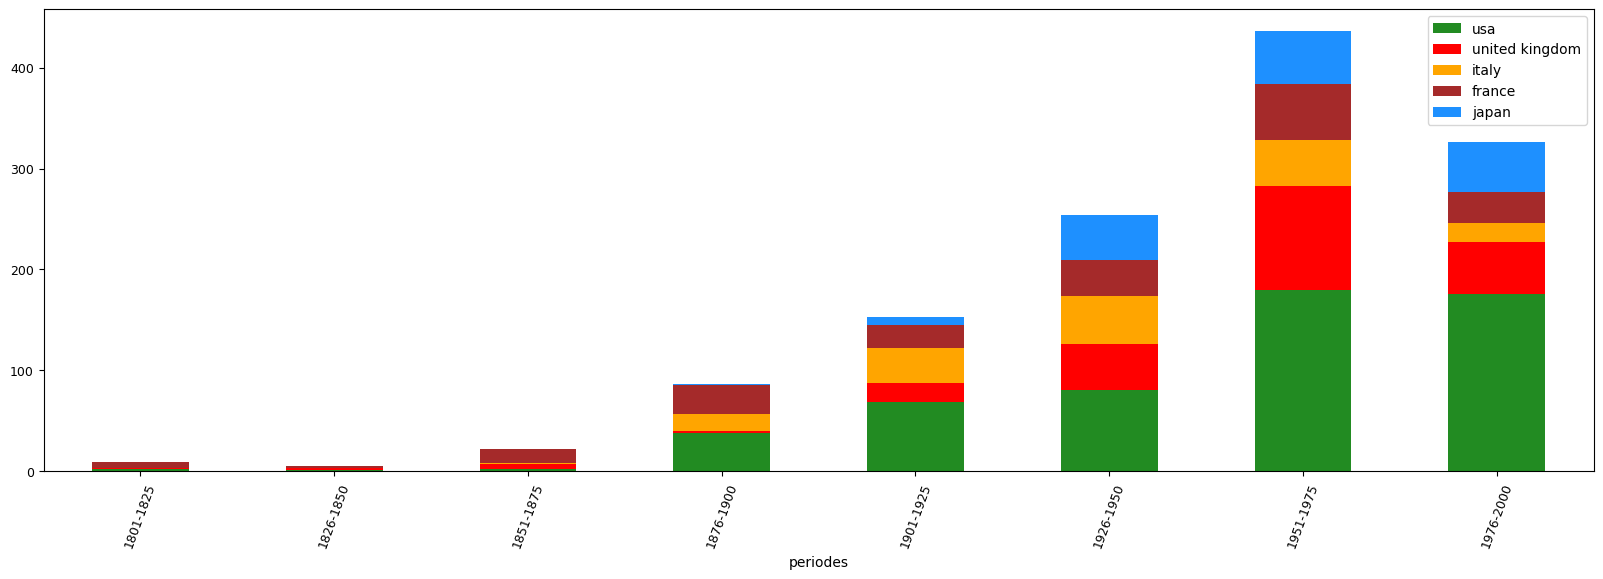

In [ ]:
### Documentation
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.bar.html
ax = merged.plot.bar(stacked=True, rot=70, fontsize=9, figsize=(20,6), color=['Forestgreen', 'Red', 'Orange','Brown','Dodgerblue'])
plt.show()

# Codage par période de dix ans

Comme on voit bien dans le graphique précédent les effectifs de la période allant de 1801 à 1850 sont très faibles et peu significatifs.On restraint donc la période analysée aux années 1850-2000 et on affine avec un découpage par périodes de dix ans

In [ ]:
l_10 = list(range(1891, 2010, 10))
l_10[:5],l_10[-5:]

([1891, 1901, 1911, 1921, 1931], [1961, 1971, 1981, 1991, 2001])

In [ ]:
### Découpage par décennies
## fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html

df_p_first_continent['per_10'] = pd.cut(df_p_first_continent['birthYear'], l_10, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
df_p_first_continent['per_10'] = df_p_first_continent['per_10'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
df_p_first_continent.head(3)

,person_label,birthYear,nationalités,continents,europe_regions,l_nationalités,l_continents,l_europe_regions,length_l_nationalités,length_l_continents,length_l_europe_regions,gender,periodes,first_continent,first_nationality,per_10
person_uri,,,,,,,,,,,,,,,,
http://www.wikidata.org/entity/Q100324415,Estrella Rivas Franco,1921,spain,Europe,southern_europe,[spain],[Europe],[southern_europe],1,1,1,F,1901-1925,Europe,spain,1921-1930
http://www.wikidata.org/entity/Q100462257,Ina Trifonova,1981,bulgaria,Europe,eastern_europe,[bulgaria],[Europe],[eastern_europe],1,1,1,F,1976-2000,Europe,bulgaria,1981-1990
http://www.wikidata.org/entity/Q101085725,Abbas Kaijuka,1989,uganda,Africa,None,[uganda],[Africa],[],1,1,0,M,1976-2000,Africa,uganda,1981-1990


In [ ]:
### Regrouper et compter avec un fitre sur le pays united states of america
nationality_usa = pd.DataFrame(df_p_first_continent[df_p_first_continent.first_nationality == 'united states of america'].groupby('per_10').size())
nationality_usa.columns = ['usa']
nationality_usa.head()


,usa
per_10,
1891-1900,27
1901-1910,28
1911-1920,18
1921-1930,41
1931-1940,33


In [ ]:
### Regrouper et compter avec un fitre sur le pays united kingdom
# Filtrer les lignes où 'first_nationality' correspond à l'une des valeurs spécifiées
nationalities_to_filter = [
    'united kingdom',
    'united kingdom of great britain and ireland',
    'kingdom of england',
    'wales',
    'england'
]

# Filtrer les lignes qui correspondent aux nationalités spécifiées
filtered_df = df_p_first_continent[df_p_first_continent['first_nationality'].isin(nationalities_to_filter)]


# Reset index without adding it as a new column
nationality_uk = filtered_df.groupby('per_10').size().reset_index(name='uk').set_index('per_10')

# Afficher les dernières lignes du DataFrame
nationality_uk.head()

,uk
per_10,
1891-1900,1
1901-1910,8
1911-1920,6
1921-1930,7
1931-1940,18


In [ ]:
### Regrouper et compter avec un fitre sur le pays italy
# Filtrer les lignes où 'first_nationality' correspond à l'une des valeurs spécifiées
nationalities_to_filter = [
    'italy',
    'kingdom of italy',
    'republic of venice',
]

# Filtrer les lignes qui correspondent aux nationalités spécifiées
filtered_df = df_p_first_continent[df_p_first_continent['first_nationality'].isin(nationalities_to_filter)]

# Reset index without adding it as a new column
nationality_it = filtered_df.groupby('per_10').size().reset_index(name='italy').set_index('per_10')

# Afficher les dernières lignes du DataFrame
nationality_it.tail()

,italy
per_10,
1951-1960,17
1961-1970,19
1971-1980,14
1981-1990,10
1991-2000,4


In [ ]:
### Regrouper et compter avec un fitre sur le pays France
nationality_fr = pd.DataFrame(df_p_first_continent[df_p_first_continent.first_nationality == 'france'].groupby('per_10').size())
nationality_fr.columns = ['france']
nationality_fr.tail()

,france
per_10,
1951-1960,24
1961-1970,19
1971-1980,23
1981-1990,15
1991-2000,6


In [ ]:
### Regrouper et compter avec un fitre sur le pays japan
nationality_ja = pd.DataFrame(df_p_first_continent[df_p_first_continent.first_nationality == 'japan'].groupby('per_10').size())
nationality_ja.columns = ['japan']
nationality_ja.tail()

,japan
per_10,
1951-1960,15
1961-1970,25
1971-1980,27
1981-1990,24
1991-2000,10


In [ ]:
dfs = [nationality_usa, nationality_uk, nationality_it, nationality_fr, nationality_ja]
# Fusionner les DataFrames en utilisant l'index comme clé de jointure
merged = pd.merge(dfs[0], dfs[1], left_index=True, right_index=True)  # Utilisation des deux premiers DataFrames pour commencer la fusion

# Fusionner les DataFrames restants un par un
for df in dfs[2:]:
    merged = pd.merge(merged, df, left_index=True, right_index=True)
merged.head()

,usa,uk,italy,france,japan
per_10,,,,,
1891-1900,27,1,8,12,1
1901-1910,28,8,16,12,4
1911-1920,18,6,11,6,1
1921-1930,41,7,14,13,10
1931-1940,33,18,16,10,16


In [ ]:
### On transforme le type de valeur de l'index
# et on ajoute une colonne avec le total
merged.index = merged.index.map(str)
merged['tot']=merged['usa']+merged['uk']+merged['italy']+merged['france']+merged['japan']
merged.tail()

,usa,uk,italy,france,japan,tot
per_10,,,,,,
1951-1960,49,30,17,24,15,135
1961-1970,87,51,19,19,25,201
1971-1980,91,35,14,23,27,190
1981-1990,94,29,10,15,24,172
1991-2000,35,9,4,6,10,64


In [ ]:
### On prépare les valeurs pour l'affichage des fréquences (proportion par rapport au total)

# liste qui contient toutes les valeurs à la suite
m_f = merged.usa.to_list()+merged.uk.to_list()+merged.italy.to_list()+merged.france.to_list()+merged.japan.to_list()

# liste d'égale longueur que la précédente qui contient
# les valeurs de l'index, i.e. les périodes
tot = merged.tot.to_list()*6

# liste qui contient les valeurs des fréquences
lp = [round(v/t, 2) for v,t in zip(m_f, tot)]
lp[:3]

[0.55, 0.41, 0.43]

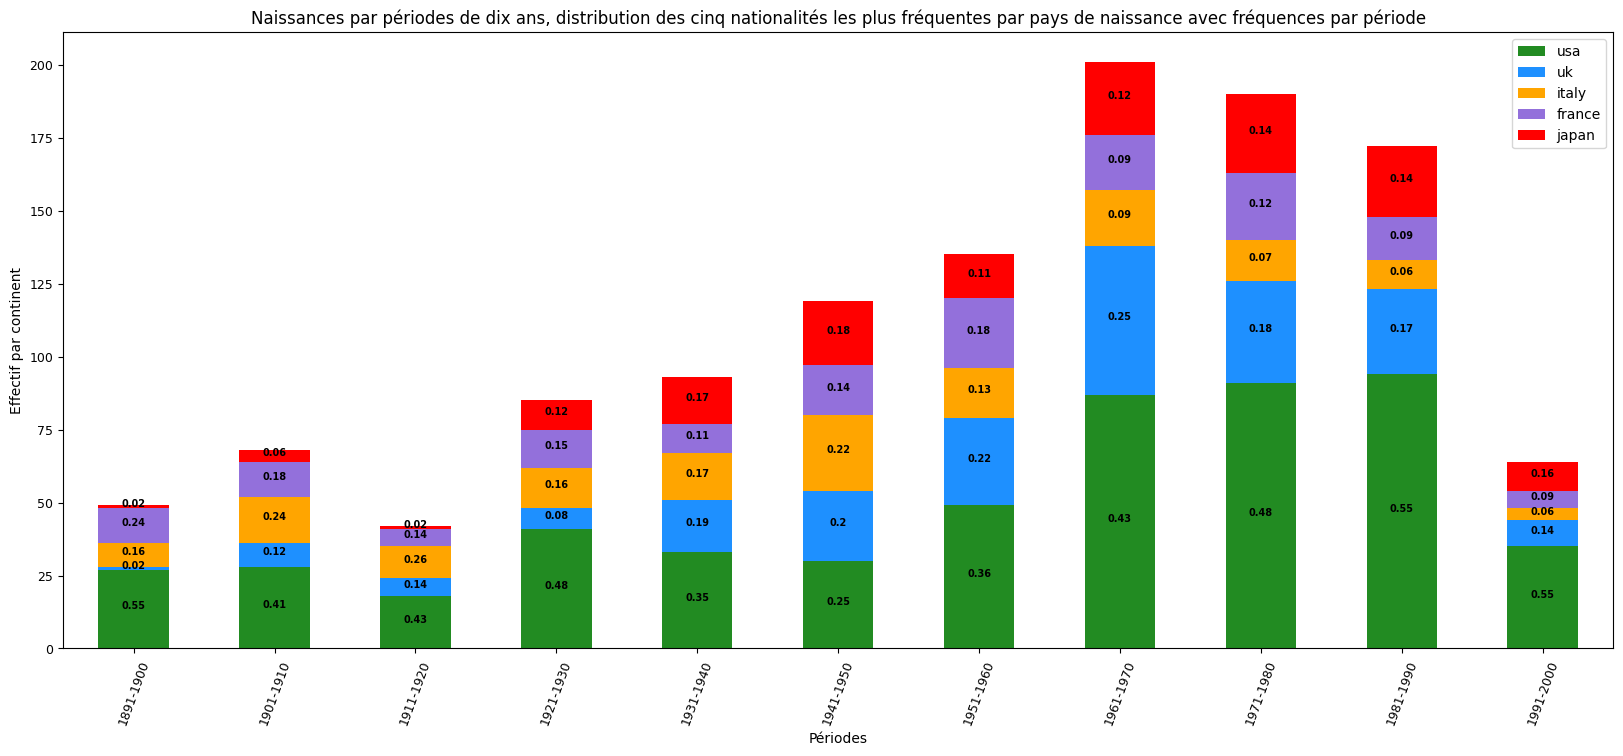

In [ ]:
import os

# Votre code pour générer le graphique
### Graphique avec la distribution par période et genre (M,F)


ax = merged.plot.bar(stacked=True, y=['usa','uk','italy', 'france', 'japan'], \
                        rot=70, fontsize=9, figsize=(20,8), color=['Forestgreen', 'Dodgerblue', 'Orange', 'Mediumpurple', 'Red'])


### https://www.pythoncharts.com/matplotlib/stacked-bar-charts-labels/


## On ajoute une étiquette concernant la valeur de fréquence
# à chaque rectangle dans le graphe, en utilisant la list 'lp' préparée précédemment
# Il y a autant de triangles que les valeurs d'index x le nombre de variables

for bar,v in zip(ax.patches,lp):

    ax.text(
      # Met les étiquette aux centre des rectangles
      bar.get_x() + bar.get_width() / 2,

      # Ajoute les coordonnées verticales
      bar.get_height()/2 + bar.get_y(),


      # Ajoute les valeurs
      v,

      # centre et met du style aux étiquettes
      ha='center',
      color='black',
      weight='bold',
      size=7
  )

plt.ylabel('Effectif par continent')
plt.xlabel('Périodes')
plt.title('Naissances par périodes de dix ans, distribution des cinq nationalités les plus fréquentes par pays de naissance avec fréquences par période')

# Créer le répertoire s'il n'existe pas déjà
directory = 'images'
if not os.path.exists(directory):
    os.makedirs(directory)

# Sauvegarder l'image dans le répertoire
plt.savefig('images/naissances_distribution_10ans_continent.jpg', bbox_inches='tight', pad_inches=0.2)
plt.show()

**Commentaire**

On constate que pour toute les époques, le pays de citoyenneté la plus représenté est les Etats-Unis.

A partir de 1911, on observe une répartition assez homogène entre les 4 nationalités suivantes avec une représentation de plus en plus marquée du Royaume-Uni.